# Compute the sequence of requests 
## Using the discrete CDF

- Fitting data for execution logs or for synthetic logs
- Generating the sequence of requests
- Computing the cost of a sequence

Input data is represented by:
 * Log data for neuroscience applications (log_example.in)
     * Array of past execution times
 * Synthetic data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import random

import HPCRequest

# Log data

This example computes the sequence of requests
- using the discrete data
- using both interpolation models (polynomial and distribution) to go through a continuous fit

In [2]:
dataset = "./log_example.in"
data = np.loadtxt(dataset, delimiter=' ')
data = [int(i/100) for i in data]
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 300


# Compute the discrete CDF

Plot it and show best fit by connecting adiacent points with a line

In [3]:
# Optimal CDF by using the discrete full data both for computing the data and for computing the cost
wf = HPCRequest.Workload(data)
optimal_data, optimal_cdf = wf.compute_cdf()

optimal_sequence = wf.compute_request_sequence()
print("Optimal sequence", optimal_sequence)

optimal_cost = wf.compute_sequence_cost(optimal_sequence, data)
print("Optimal cost", optimal_cost)

Optimal sequence [(808,), (990,)]
Optimal cost 870.7


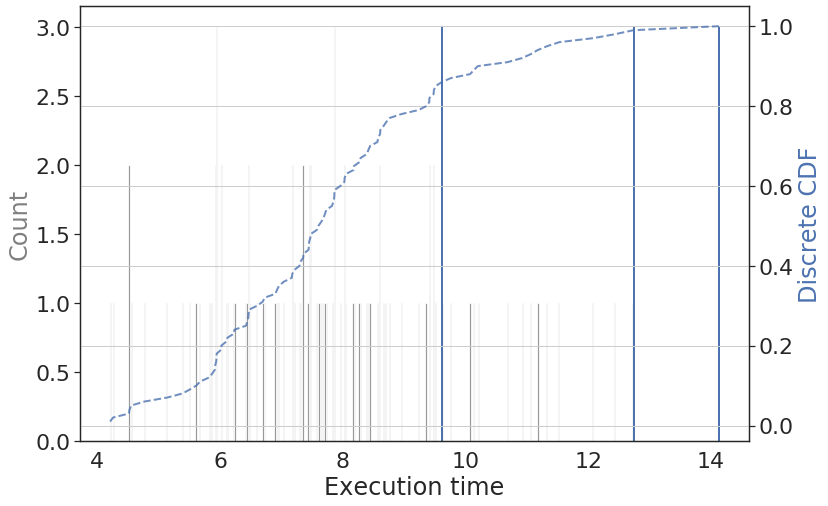

In [29]:
# plot the data and the discrete CDF (consecutive points joined by a line)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot discrete fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8)

plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF', color="b")
ax.set_ylabel('Count', color="grey")
plt.show()

# Interpolate the CDF with a distribution fit

- get best disribution base on the fit

In [5]:
# compute the interpolation of the CDF (for full data)
wf.set_interpolation_model([HPCRequest.DistInterpolation(data)])
best_fit = wf.get_best_fit()

In [6]:
all_data_discrete, all_data_cdf = wf.compute_cdf()
distr_sequence = wf.compute_request_sequence()
print("Distribution sequence", distr_sequence)

Distribution sequence [(773,), (990,)]


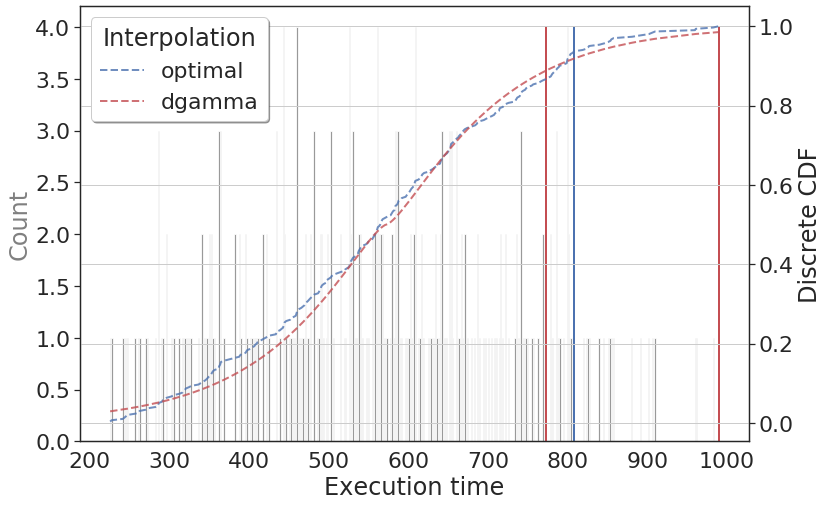

In [7]:
# plot the data and the interpolation CDF

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
#plt.savefig("docs/sequence.png")
plt.show()

# Use only the first x entries in data for interpolation

In [24]:
# define x
training_size = 10

In [25]:
training_data = random.sample(list(data), training_size)
wf = HPCRequest.Workload(training_data)
discret_data, cdf = wf.compute_cdf()

discrete_sequence = wf.compute_request_sequence(max_request=max(data))
print("Discrete sequence", discrete_sequence)
print("Discrete cost", wf.compute_sequence_cost(discrete_sequence, data))

Discrete sequence [(9.41007879572334,), (12.43754699011903,), (14.128597606029487,)]
Discrete cost 11.931409206065382


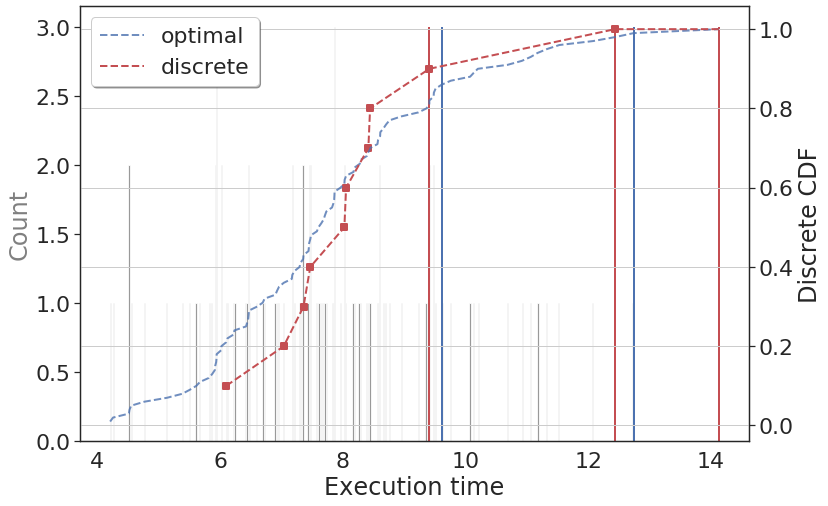

In [26]:
# plot the fit of the discrete fit (using the first x entries)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')


# plot the discrete sequence
ax.vlines(discrete_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# plot sample data
ax2.plot(discret_data + [max(data)], cdf + [1], 'r--', lw=2, alpha=1, label="discrete")
ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

ax2.legend(shadow=True)
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
plt.show()

# Distribution interpolation

In [27]:
# compute the interpolation of the CDF points
wf.set_interpolation_model([HPCRequest.DistInterpolation(training_data)])

distr_sequence = wf.compute_request_sequence(max_request=max(data))

best_fit = wf.get_best_fit()
print(best_fit)
all_data_discrete, all_data_cdf = wf.compute_cdf(data=data)

print("Distribution sequence", distr_sequence)
print("Distribution cost", wf.compute_sequence_cost(distr_sequence, data))

(<scipy.stats._continuous_distns.laplace_gen object at 0x7fc69138c400>, (8.044652576051748, 1.0770709760791974), 1.9858764150873671)
Distribution sequence [(9.41007879572334,), (12.43754699011903,), (14.128597606029487,)]
Distribution cost 11.931409206065382


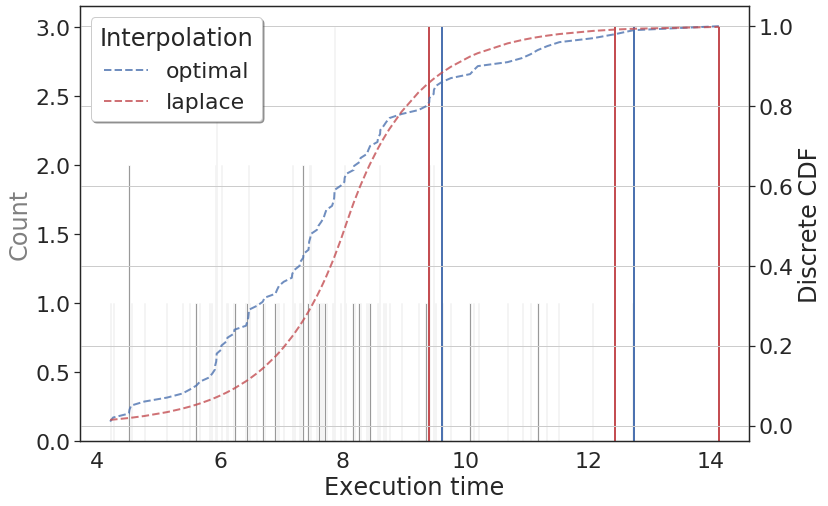

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
plt.show()